<a href="https://colab.research.google.com/github/seototheyoon/projrct/blob/main/vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Final Project***
---

In this project, you will develop a convolutional neural network (CNN) to perform classification, and test it out on the CIFAR-10 dataset.


The given code is a simple implement for the CIFAR-10 classification.

The goal of the final project is to check whether you understand important concepts for training CNN such as:

*   Network architecture
*   Optimization
*   Loss function
*   Data preprocessing
*   Regularization
*   ...

Therefore, you can **modify the given code to improve the performance** of the network **except for the dataset (i.e. trainset and testset)**.

You should **upload your code and your report** including an explaination of your code and what you have changed or added.

In [24]:
# AS usual, a bit of setup
# If you need other libraries, you should import the libraries.

import os, sys
import torch
from torch import nn
from torch.nn import functional as F

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
import numpy as np

In [25]:
# Set the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# **Data Loader**

You can load the CIFAR-10 dataset using the library `torchvision.datasets`

The details of CIFAR-10 dataset can be found in https://www.cs.toronto.edu/~kriz/cifar.html

`transforms_cifar10` is used to assemble several transforms for data preprossing.

In [26]:
# Train data preprocessing (with augmentation + scaling)
transforms_cifar10_train = transforms.Compose([
    transforms.Resize((36, 36)),
    transforms.RandomCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.5)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))
])

# Test data preprocessing (with scaling only)
transforms_cifar10 = transforms.Compose([transforms.Resize((32, 32)),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                 ])

# Train dataset
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms_cifar10)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)
#배치 사이즈 바꿔도 됨, 셔플은 학습순서 기억하지 못하도록 하기 위해 사용.

# Test dataset
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms_cifar10)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)
#배치 사이즈 바꿔도 됨, test는 셔플 필요없음 .

# Classes of CIFAR-10 dataset
classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

truck truck   dog plane


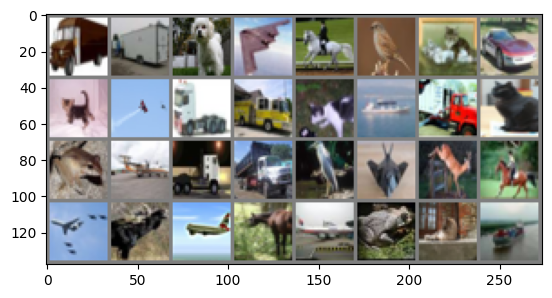

In [27]:
# Examples of dataset

def imshow(img):
  img = img /2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(trainloader)
imgs, labels = next(dataiter)

imshow(torchvision.utils.make_grid(imgs))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# **Your own CNN**

You can implement your own network using libraries such as `torch.nn`and `torch.nn.functional`.

`SimpleNet` and `VGG11` are examples to help your understand the implementation of the network.

So, you can modify the given codes or create another awesome neural network for CIFAR-10 classification.

In [33]:
#누리님 model 수정본 (81%)

import torchvision.models as models

vgg16 = models.vgg16_bn(pretrained=False)
vgg16.classifier[6] = nn.Linear(4096, 10)
vgg16 = vgg16.to(device)

class vgg16(nn.Module):
    def __init__(self, num_classes=10):
        super(vgg16, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),  # padding=1 preserves size
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # downsample (32→16)

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # downsample (16→8)

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # downsample (8→4)
        )

        # Adaptive pooling for flexibility in input size
        self.avgpool = nn.AdaptiveAvgPool2d((4, 4))

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.classifier(x)
        return x

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


# **Loss function and optimizer**

Set the **loss function and optimizer** for training CNN.
You can modify the loss function or optimizer for better performance.

In [34]:
#SGD + Momentum + StepLR 조합으로 수정(Adam + CosineAnnealingLR 조합보다 정확도 높음, 단 추가 실험 필요)
net = vgg16(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# 정확도 계산 함수
def compute_accuracy(model, dataloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return 100 * correct / total

# **Train the network**

Train your own network using the above loss function and optimizer.

In [30]:
# Train the model
epochs = 30  # number of epochs

for epoch in range(epochs):

    loss_tmp = 0.0
    epoch_loss = 0.0
    for i, data in enumerate(trainloader, start=0):
        # Load the data
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Estimate the output using the network
        outputs = net(inputs)

        # Calculate the loss between the output of the network and label
        loss = criterion(outputs, labels)

        # Optimize the network
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_tmp += loss.data
        epoch_loss += loss.data

        if i % 5000 == 4999:    # Print loss every 5000 mini-batches
            print('[Epoch - %d, Iteration - %5d] Loss: %.3f' %
                  (epoch + 1, i + 1, loss_tmp / (i+1)))
            loss_tmp = 0.0

    # Update the learning rate according to the learnig rate scheduler
    scheduler.step()

    # Print the epoch loss
    print('[Epoch - %d] Loss: %.3f' %(epoch + 1, epoch_loss / (i+1)))

print('Finished Training')

[Epoch - 1] Loss: 1.436
[Epoch - 2] Loss: 0.936
[Epoch - 3] Loss: 0.749
[Epoch - 4] Loss: 0.628
[Epoch - 5] Loss: 0.547
[Epoch - 6] Loss: 0.470
[Epoch - 7] Loss: 0.408
[Epoch - 8] Loss: 0.355
[Epoch - 9] Loss: 0.307
[Epoch - 10] Loss: 0.264
[Epoch - 11] Loss: 0.141
[Epoch - 12] Loss: 0.101
[Epoch - 13] Loss: 0.084
[Epoch - 14] Loss: 0.070
[Epoch - 15] Loss: 0.058
[Epoch - 16] Loss: 0.051
[Epoch - 17] Loss: 0.043
[Epoch - 18] Loss: 0.039
[Epoch - 19] Loss: 0.038
[Epoch - 20] Loss: 0.027
[Epoch - 21] Loss: 0.014
[Epoch - 22] Loss: 0.009
[Epoch - 23] Loss: 0.007
[Epoch - 24] Loss: 0.007
[Epoch - 25] Loss: 0.005
[Epoch - 26] Loss: 0.005
[Epoch - 27] Loss: 0.005
[Epoch - 28] Loss: 0.004
[Epoch - 29] Loss: 0.004
[Epoch - 30] Loss: 0.004
Finished Training


# **Test the network**

Test the trained network using the testset.

Accuracy of the network on the 10,000 test images is the final accuracy of your network.

The closer the accuray is to 100%, the better the network classifies the input image.

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship   car plane


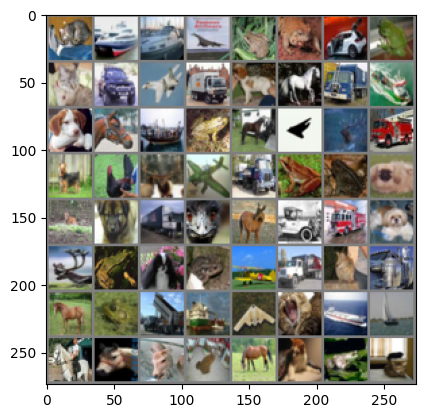

In [31]:
# Test the trained model with sample

dataiter_test = iter(testloader)
img_test, labels_test = next(dataiter_test)

imshow(torchvision.utils.make_grid(img_test))
print('GroundTruth: ', ' '.join('%5s' % classes[labels_test[j]] for j in range(4)))

img_test = img_test.to(device)
labels_test = labels_test.to(device)

# Prediction
outputs_test = net(img_test)
_, predicted = torch.max(outputs_test.data, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

In [32]:
# Test the trained model with overall test dataset

correct = 0
total = 0
for data in testloader:
    # Load the data
    inputs_test, labels_test = data
    inputs_test = inputs_test.to(device)
    labels_test = labels_test.to(device)

    # Estimate the output using the trained network
    outputs_test = net(inputs_test)
    _, predicted = torch.max(outputs_test.data, 1)

    # Calculate the accuracy
    total += labels_test.size(0)
    correct += (predicted == labels_test).sum()

# Final accuracy
print('Accuracy of the network on the 10,000 test images: %d %%' % (100 * correct / total))


## [SimpleNet / Training 5 epochs] Accuracy of the network on the 10,000 test images: 9 %
## [VGG11 / Training 5 epochs] Accuracy of the network on the 10,000 test images: 12 %

Accuracy of the network on the 10,000 test images: 84 %
